In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import argparse

## 1. `generate_dataset` — 多種二維分類資料產生器

**功能**  
- 依照使用者指定的 `dataset_type`，動態產生常見的二維 toy data：  
  - `moons`、`circles`、`blobs`、`linear`、`xor`

**重要參數**  
- `dataset_type`：資料集類型  
- `n_samples`：產生的總樣本數（可指定成 tuple 分別控制各類數量）  
- `noise`：雜訊標準差（僅對 `moons`、`circles`、`xor` 有效）  
- `centers`：`blobs` 中群聚中心數量  
- `factor`：`circles` 內外圈半徑比例  

In [28]:
def generate_dataset(dataset_type='moons',
                     n_samples=200,
                     noise=0.2,
                     centers=3,
                     factor=0.5,
                     random_state=42):
    """產生多種二維分類資料"""
    if dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples,
                          noise=noise,
                          random_state=random_state)
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples,
                            noise=noise,
                            factor=factor,
                            random_state=random_state)
    elif dataset_type == 'blobs':
        X, y = make_blobs(n_samples=n_samples,
                          centers=centers,
                          random_state=random_state)
    elif dataset_type == 'linear':
        X, y = make_blobs(n_samples=n_samples,
                          centers=2,
                          cluster_std=0.5,
                          random_state=random_state)
    elif dataset_type == 'xor':
        np.random.seed(random_state)
        base = np.array([[0,0],[0,1],[1,0],[1,1]])
        labels = np.array([0,1,1,0])
        X = base + noise * np.random.randn(*base.shape)
        y = labels
    else:
        raise ValueError(f"不支援的 dataset_type: {dataset_type}")
    return X, y

## 2. `plot_dataset` — 資料分佈視覺化

**功能**  
- 將 2D 特徵 `X` 及標籤 `y` 繪製成散佈圖，方便觀察資料分佈形狀。  

**重要參數**  
- `X` (array): 特徵矩陣，shape=(n_samples, 2)  
- `y` (array): 標籤向量，shape=(n_samples,)  
- `title` (str): 圖片標題  


In [29]:
def plot_dataset(X, y, title='Dataset'):
    """繪製原始資料分佈"""
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr',
                edgecolors='k', s=50)
    plt.title(title)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.grid(alpha=0.3)
    plt.show()

## 3a. `train_mlp_sklearn` — 使用 Scikit-learn 訓練 MLP

**功能**  
- 利用 `sklearn.neural_network.MLPClassifier` 快速定義並訓練多層感知器 (MLP)。  

**重要參數**  
- `hidden_layers` (tuple): 隱藏層神經元數量，例如 `(10, 10)`  
- `activation` (str): 隱藏層激活函數 (`'identity'`,`'logistic'`,`'tanh'`,`'relu'`)  
- `solver` (str): 最佳化演算法 (`'lbfgs'`,`'sgd'`,`'adam'`)  
- `lr` (float): 初始學習率 (`learning_rate_init`)  
- `max_iter` (int): 最大迭代次數  
- `verbose` (bool): 是否顯示每次迭代的 loss  


In [30]:
def train_mlp_sklearn(X_train, y_train,
                      hidden_layers=(10,10),
                      activation='relu',
                      solver='adam',
                      lr=0.01,
                      max_iter=200,
                      random_state=42,
                      verbose=True):
    """使用 scikit-learn MLPClassifier 訓練"""
    clf = MLPClassifier(hidden_layer_sizes=hidden_layers,
                        activation=activation,
                        solver=solver,
                        learning_rate_init=lr,
                        max_iter=max_iter,
                        random_state=random_state,
                        verbose=verbose)
    clf.fit(X_train, y_train)
    return clf

## 3b. `train_mlp_numpy` — 純 NumPy 手寫 MLP

**功能**  
- 從零實作 MLP forward/backward，使用 MSE loss 及 SGD 更新，適合作為教學示範。  

**重要參數**  
- `hidden_layers` (tuple): 隱藏層神經元數量  
- `activation` (str): 隱藏層激活函數 (`'tanh'` 或 `'relu'`)  
- `lr` (float): 學習率  
- `max_iter` (int): 最大訓練迭代次數  
- `verbose` (bool): 是否印出每 N 次迭代的 loss  

In [31]:
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size
        self.parameter = {'name':'Linear', 'size':[n_in, n_out], 'activation':activation}

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation is 'relu':
            output = np.maximum(0, output)
        if self.activation is 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        if self.activation is 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output
    def backward(self, dout):
        if self.activation is 'relu':
            self.activated_output[self.activated_output <= 0] = 0
            self.activated_output[self.activated_output > 0] = 1
            dout = dout * self.activated_output
        if self.activation is 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        if self.activation is 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

class SoftMax:
    y_hat = []

    def __init__(self):
        super(SoftMax, self).__init__()
        self.parameter = {'name':'SoftMax'}

    def forward(self, x):
        x_exp = np.exp(x)
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):

        self.layer_list = [[hidden_layer_sizes[i], hidden_layer_sizes[i + 1]]
                           for i in range(len(hidden_layer_sizes) - 1)]
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, activation, lr=lr)
        self.softmax = SoftMax()
        self.batch_size = batch_size
        self.lr = lr

        self.layers = [self.input_layer]
        for i in range(len(self.layer_list)):
            self.layers.append(LinearLayer(self.layer_list[i][0], self.layer_list[i][1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)
    def forward(self, x):
          for layer in self.layers:
              x = layer.forward(x)
          return x

    def backward(self, y):
          for layer in reversed(self.layers):
              y = layer.backward(y)

    def dataloader(batch_size, shuffle=True):
      train_data = pd.read_csv('mnist_train.csv').values
      test_data = pd.read_csv('mnist_test.csv').values
      train_X = train_data[:, 1:]
      train_y = train_data[:, 0]
      test_X = test_data[:, 1:]
      test_y = test_data[:, 0]
      len_train_data = len(train_X)
      len_test_data = len(test_X)
      train_dataset = []
      test_dataset = []
      for i in range(len(train_X)):
          train_dataset.append((train_X[i], train_y[i]))
      for i in range(len(test_X)):
          test_dataset.append((test_X[i], test_y[i]))
      train_iter = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=shuffle)
      test_iter = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=shuffle)
      return train_iter, test_iter, len_train_data, len_test_data

def train_mlp_numpy(model, dataloader, num_epochs=100, batch_size=256):
    """
    使用 tqdm 對 MLP 進行訓練

    參數:
      model       : 已實作 .forward(), .backward(), .parameter() 的 MLP 物件
      dataloader  : 一個函式，呼叫 dataloader(batch_size) 回傳
                    train_iter, test_iter, len_train_data, len_test_data
      num_epochs  : 訓練總 epoch
      batch_size  : 每次 batch 大小

    回傳:
      history     : list of 每個 epoch 完成後的累積訓練準確率
    """
    # 取得資料迭代器與資料長度
    train_iter, test_iter, len_train_data, len_test_data = dataloader(batch_size)
    # 初始化模型參數
    model.parameter()

    history = []
    for epoch in range(1, num_epochs + 1):
        acc = 0.0
        # 使用 tqdm 顯示進度條
        with tqdm(train_iter, unit='batch') as tepoch:
            tepoch.set_description(f"Epoch {epoch} train")
            for data, label in tepoch:
                # 若最後一個 batch 不足 batch_size，就略過
                if data.shape[0] < batch_size:
                    break
                # 轉換成 NumPy 陣列
                x = data.numpy()
                y = label.numpy()
                # forward 與計算 batch 準確率
                outputs = model.forward(x)
                acc += (outputs.argmax(1) == y).sum() / len_train_data
                # backward (以 one-hot label)
                model.backward(np.eye(model.num_classes)[y])
                tepoch.set_postfix(acc=acc)
        history.append(acc)
    return history

## 4. `plot_loss_curve` — 損失曲線繪製

**功能**  
- 自動判別 Sklearn 或 NumPy MLP，畫出每次迭代的 loss 變化。  

In [32]:
def plot_loss_curve(clf):
    """繪製訓練損失曲線 (Sklearn or NumPy)"""
    plt.figure(figsize=(6,4))
    if hasattr(clf, 'loss_curve_'):
        plt.plot(clf.loss_curve_, label='Sklearn Loss')
    else:
        plt.plot(clf['loss_history'], label='NumPy Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()



## 5. `plot_decision_boundary` — 決策邊界示意

**功能**  
- 在整體輸入空間網格上用模型 `predict` 填色，並疊加訓練/測試點。  

In [33]:
def plot_decision_boundary(clf, X, y, X_train, y_train, X_test, y_test):
    """畫出決策邊界 (僅示範 Sklearn 版)"""
    xx, yy = np.meshgrid(
        np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300),
        np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    if hasattr(clf, 'predict'):
        Z = clf.predict(grid).reshape(xx.shape)
    else:
        Z = clf['predict'](grid).reshape(xx.shape)

    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='bwr',
                edgecolors='k', s=50, label='Train')
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='cool',
                marker='x', s=80, label='Test')
    plt.title("Decision Boundary")
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()
    plt.show()

def evaluate_model(clf, X_train, y_train, X_test, y_test):
    """列印準確率"""
    if hasattr(clf, 'score'):
        tr = clf.score(X_train, y_train)
        te = clf.score(X_test, y_test)
    else:
        y_pred_tr = clf['predict'](X_train)
        y_pred_te = clf['predict'](X_test)
        tr = np.mean(y_pred_tr == y_train)
        te = np.mean(y_pred_te == y_test)
    print(f"Train accuracy: {tr:.3f}")
    print(f"Test accuracy:  {te:.3f}")

## 7. `__main__` — 主程式流程

1. **命令列參數解析**  
2. **資料產生與可視化**  
3. **資料切分 (Train/Test)**  
4. **Sklearn MLP 訓練、繪圖、評估**  
5. **NumPy MLP 訓練、繪圖、評估**  

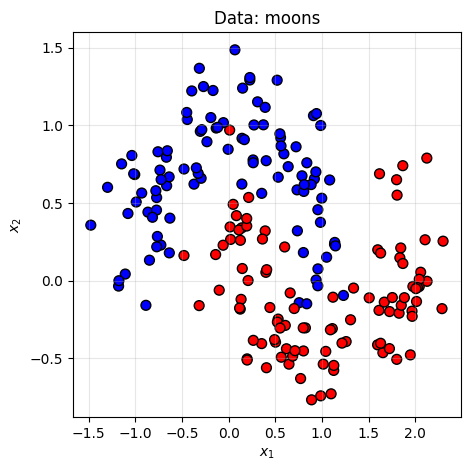

=== Sklearn MLP Training ===
Iteration 1, loss = 0.72796223
Iteration 2, loss = 0.71927743
Iteration 3, loss = 0.71145758
Iteration 4, loss = 0.70458029
Iteration 5, loss = 0.69839744
Iteration 6, loss = 0.69275274
Iteration 7, loss = 0.68745545
Iteration 8, loss = 0.68228752
Iteration 9, loss = 0.67713798
Iteration 10, loss = 0.67188490
Iteration 11, loss = 0.66653195
Iteration 12, loss = 0.66105051
Iteration 13, loss = 0.65533947
Iteration 14, loss = 0.64940180
Iteration 15, loss = 0.64306466
Iteration 16, loss = 0.63626049
Iteration 17, loss = 0.62865594
Iteration 18, loss = 0.62028553
Iteration 19, loss = 0.61121808
Iteration 20, loss = 0.60140743
Iteration 21, loss = 0.59056852
Iteration 22, loss = 0.57873006
Iteration 23, loss = 0.56592975
Iteration 24, loss = 0.55186242
Iteration 25, loss = 0.53698923
Iteration 26, loss = 0.52189402
Iteration 27, loss = 0.50677781
Iteration 28, loss = 0.49194549
Iteration 29, loss = 0.47769387
Iteration 30, loss = 0.46409764
Iteration 31, loss =

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


NameError: name 'MLP' is not defined

In [39]:
if __name__ == '__main__':
    # ------------------------------
    # 0. 引入 argparse（請務必在此 cell/模組開頭 import argparse）
    # ------------------------------
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset',   type=str, default='moons',
                        choices=['moons','circles','blobs','linear','xor'],
                        help='選擇資料類型')
    parser.add_argument('--n_samples', type=int, default=200,
                        help='樣本總數')
    parser.add_argument('--noise',     type=float, default=0.2,
                        help='資料雜訊程度')
    parser.add_argument('--centers',   type=int, default=3,
                        help='blobs 群聚中心數')
    parser.add_argument('--factor',    type=float, default=0.5,
                        help='circles 內外圈比例')
    args, _ = parser.parse_known_args()

    # ------------------------------
    # 1. 產生並可視化資料
    # ------------------------------
    X, y = generate_dataset(dataset_type=args.dataset,
                            n_samples=args.n_samples,
                            noise=args.noise,
                            centers=args.centers,
                            factor=args.factor)
    plot_dataset(X, y, title=f"Data: {args.dataset}")

    # ------------------------------
    # 2. 切分訓練/測試集
    # ------------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

    # ------------------------------
    # 3a. 訓練 Sklearn MLP
    # ------------------------------
    print("=== Sklearn MLP Training ===")
    clf_sk = train_mlp_sklearn(X_train, y_train)

    # ------------------------------
    # 3b. 訓練 NumPy MLP
    # ------------------------------
    print("\n=== NumPy MLP Training ===")
    num_epochs = 100
    batch_size = 256

    # 建立模型
    model = MLP(input_size=784, batch_size=batch_size,
                num_classes=10, lr=0.001,
                hidden_layer_sizes=(256,),
                activation='tanh')
    # 執行訓練
    history = train_mlp_numpy(model, MLP.dataloader,
                              num_epochs=num_epochs,
                              batch_size=batch_size)
    # ------------------------------
    # 4a. Sklearn MLP 結果
    # ------------------------------
    print("\n--- Sklearn MLP Results ---")
    plot_loss_curve(clf_sk)
    plot_decision_boundary(clf_sk, X, y, X_train, y_train, X_test, y_test)
    evaluate_model(clf_sk, X_train, y_train, X_test, y_test)

    # ------------------------------
    # 4b. NumPy MLP 結果
    # ------------------------------
    plt.plot(clf_np_imp['loss_history'])
    plt.title("Improved NumPy MLP Loss")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.show()
    # 決策邊界 & 評估
    plot_decision_boundary(clf_np_imp, X, y, X_train, y_train, X_test, y_test)
    acc = np.mean(clf_np_imp['predict'](X_test) == y_test)
    print("Improved NumPy MLP Test Acc:", acc)